In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#! pip3 install xgboost
from xgboost import XGBRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LinearRegression


In [61]:
data = pd.read_csv('Data/data_with_new_features.csv')
print(len(data))
data.head()

376912


,Unnamed: 0,id,time,variable,value,date,timeOfDay,year,month,day,phaseOfDay
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0,2014-02-26,13:00:00.000,2014,2,26,1
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0,2014-02-26,15:00:00.000,2014,2,26,1
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0,2014-02-26,18:00:00.000,2014,2,26,2
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0,2014-02-26,21:00:00.000,2014,2,26,2
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0,2014-02-27,09:00:00.000,2014,2,27,0


In [54]:
print("There are {} users in this dataset".format(len(data["id"].unique())))
print("Tere are {} variables in this dataset and these variables are {}".format(len(data["variable"].unique()), data["variable"].unique()))
users = data["id"].unique()
average_num_of_timesteps = np.mean([len(data[data["id"]==user]) for user in users])
print("The average num of timesteps per user is {:.6}".format(average_num_of_timesteps))


There are 27 users in this dataset
Tere are 19 variables in this dataset and these variables are ['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']
The average num of timesteps per user is 13959.7


Average mood is 6.993 with std of 1.033


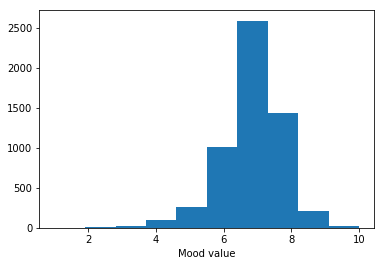

In [62]:
mood_values = data[data["variable"]=="mood"]["value"]
print("Average mood is {:.4} with std of {:.4}".format(np.mean(mood_values), np.std(mood_values)))
plt.hist(mood_values)
plt.xlabel("Mood value")
plt.show()

Average mood per user is 6.995 with std of 0.377


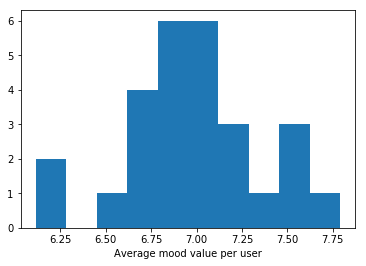

In [63]:
mood_values_per_user = data[data["variable"]=="mood"].groupby(by="id")['value'].mean()
print("Average mood per user is {:.4} with std of {:.4}".format(np.mean(mood_values_per_user), np.std(mood_values_per_user)))
plt.hist(mood_values_per_user)
plt.xlabel("Average mood value per user")
plt.show()



In [64]:
#helper function to compare two dates, obsolete

def slice(datum, x = 10):
    return datum[:x]

def get_date_data_frame(data):
    return pd.DataFrame(list(map(slice , data["time"])))






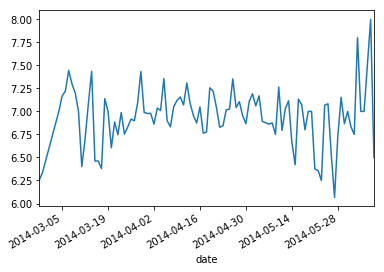

In [65]:
#getting dates and setting them as indexis
data["date"] = get_date_data_frame(data)
data['date'] = pd.to_datetime(data['date'])
data= data.set_index(['id', 'date'])

data[data['variable']=='mood']['value'].groupby(level = 'date').mean().plot()
plt.show()

Features to investigate and how to aggregate. <br />
Mood = average per day, average for t days <br /> circumplex.arousal = average<br /> circumplex.valence = average <br />
activity = average per day <br />
screen = sum per day,  average along several days, sum along days <br />
call = sum per day, average along several days, sum along days <br />
sms = sum per day, average along several days, sum along days <br />
for each in ['appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']:
 sum per day.  <br />
 
 Also days which are closer to t can be scored higher
 

In [167]:
variables = data['variable'].unique()
#generating new df
date_data = pd.DataFrame(index = data.index)
sum_variables =  [ 'screen',
 'call', 'sms' ,'appCat.builtin', 'appCat.communication',
 'appCat.entertainment', 'appCat.finance', 'appCat.game' ,'appCat.office',
 'appCat.other', 'appCat.social', 'appCat.travel' ,'appCat.unknown',
 'appCat.utilities' ,'appCat.weather']
mean_variables = ['mood', 'circumplex.arousal', 'circumplex.valence','activity']

#grouping by id and date. creating a column for value for that day with either mean or sum (described in markdown)
for variable in variables:
    if variable in sum_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].sum()#.reset_index(level=['id']).resample('D').sum()
    elif variable in mean_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].mean()#.reset_index(level=['id']).resample('D').mean()

# add temporal variables
date_data['dayofweek'] = date_data.index.get_level_values('date').dayofweek
date_data['phaseOfDay'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['phaseOfDay'].mean()#.
date_data['day'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['day'].mean()#.

# add leisure variable
date_data['leisure'] = (date_data['appCat.entertainment']+date_data['appCat.game'])

#target at day is the same as mood at day
date_data['target'] = date_data['mood']

#droping duplicates
date_data.drop_duplicates( keep='first', inplace=True)

#filling missing values were NaN means 0
values0 = {key: 0 for key in sum_variables}
values0['leisure'] = 0

date_data.fillna(value=values0, inplace=True)
date_data[mean_variables]=  date_data[mean_variables].fillna( method =  'ffill')


In [68]:
date_data.head()

mood  circumplex.arousal  circumplex.valence  \
id      date                                                           
AS14.01 2014-02-26  6.250000               -0.25            0.750000   
        2014-02-27  6.333333                0.00            0.333333   
        2014-03-21  6.200000                0.20            0.200000   
        2014-03-22  6.400000                0.60            0.500000   
        2014-03-23  6.800000                0.20            0.800000   

                    activity        screen  call  sms  appCat.builtin  \
id      date                                                            
AS14.01 2014-02-26       NaN      0.000000   1.0  2.0           0.000   
        2014-02-27       NaN      0.000000   0.0  0.0           0.000   
        2014-03-21  0.134050  17978.907000   6.0  0.0        3139.218   
        2014-03-22  0.236880   6142.161000   3.0  1.0         731.429   
        2014-03-23  0.142741   6773.832001   0.0  0.0        1286.246   

                    appCat.communication  appCat.entertainment    ...     \
id      date                                                      ...      
AS14.01 2014-02-26                 0.000                 0.000    ...      
        2014-02-27                 0.000                 0.000    ...      
        2014-03-21              6280.890              1007.456    ...      
        2014-03-22              4962.918                93.324    ...      
        2014-03-23              5237.319                94.346    ...      

                    appCat.social  appCat.travel  appCat.unknown  \
id      date                                                       
AS14.01 2014-02-26          0.000          0.000             0.0   
        2014-02-27          0.000          0.000             0.0   
        2014-03-21       4508.500        915.445             0.0   
        2014-03-22        439.632         37.305             0.0   
        2014-03-23        900.839          0.000             0.0   

                    appCat.utilities  appCat.weather  dayofweek  phaseOfDay  \
id      date                                                                  
AS14.01 2014-02-26             0.000           0.000          2    1.500000   
        2014-02-27             0.000           0.000          3    0.666667   
        2014-03-21           598.754           0.000          4    1.000000   
        2014-03-22           117.621           0.000          5    1.200000   
        2014-03-23            30.086          30.386          6    1.200000   

                     day  leisure    target  
id      date                                 
AS14.01 2014-02-26  26.0      0.0  6.250000  
        2014-02-27  27.0      0.0  6.333333  
        2014-03-21  21.0      0.0  6.200000  
        2014-03-22  22.0      0.0  6.400000  
        2014-03-23  23.0      0.0  6.800000  

[5 rows x 24 columns]

In [69]:
# get information about new features
date_data.corr(method='pearson')['target']

mood                    1.000000
circumplex.arousal      0.152953
circumplex.valence      0.685225
activity                0.137491
screen                  0.044116
call                    0.027335
sms                    -0.042579
appCat.builtin          0.014357
appCat.communication    0.052336
appCat.entertainment    0.088920
appCat.finance          0.018277
appCat.game             0.070238
appCat.office           0.040168
appCat.other            0.083600
appCat.social          -0.050132
appCat.travel           0.024133
appCat.unknown          0.030130
appCat.utilities        0.041552
appCat.weather          0.018164
dayofweek               0.096071
phaseOfDay             -0.021719
day                    -0.040271
leisure                 0.120285
target                  1.000000
Name: target, dtype: float64

In [187]:
lagged_date_data = date_data.copy()
#rolling mean
lag = 10
rolling_variables  = list(lagged_date_data.columns)
rolling_variables.remove("dayofweek")
rolling_variables.remove("day")

#for lag in range(1,max_lag):
for variable in rolling_variables:
    if variable == "day" or variable == "dayofweek":
        lagged_date_data[variable+"_not_lagged"] = lagged_date_data[variable]
    else:
        lagged_date_data["{}_lagged_by_{}".format(variable, lag)]=lagged_date_data[variable].rolling(window = lag).mean()
#creating variables to drop

list_var = rolling_variables
print(list_var)
list_var.remove('target')

['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'phaseOfDay', 'leisure', 'target']


In [71]:
print("users:",len(lagged_date_data.index.get_level_values('id').unique()))
print("data points (user-date pairs):",len(lagged_date_data.index.get_level_values('id')))
lagged_date_data

users: 27
data points (user-date pairs): 1564


mood  circumplex.arousal  circumplex.valence  \
id      date                                                           
AS14.01 2014-02-26  6.250000           -0.250000            0.750000   
        2014-02-27  6.333333            0.000000            0.333333   
        2014-03-21  6.200000            0.200000            0.200000   
        2014-03-22  6.400000            0.600000            0.500000   
        2014-03-23  6.800000            0.200000            0.800000   
        2014-03-24  6.000000            0.800000            0.000000   
        2014-03-25  6.750000            0.500000            0.500000   
        2014-03-26  6.600000           -0.200000            0.600000   
        2014-03-27  7.000000            0.200000            0.800000   
        2014-03-28  6.400000           -0.600000            0.600000   
        2014-03-29  8.000000            0.200000            1.000000   
        2014-03-30  7.500000           -0.500000            0.750000   
        2014-03-31  7.400000            0.000000            0.600000   
        2014-04-01  6.000000            0.200000            0.000000   
        2014-04-02  6.500000            0.333333            0.666667   
        2014-04-03  6.400000           -1.200000            0.000000   
        2014-04-04  6.200000            0.200000            0.400000   
        2014-04-05  6.800000           -0.400000            0.600000   
        2014-04-06  6.500000           -0.750000            0.500000   
        2014-04-07  6.500000           -0.666667            0.250000   
        2014-04-08  6.600000           -0.400000            0.333333   
        2014-04-09  7.400000           -0.800000            1.000000   
        2014-04-10  7.400000           -0.400000            0.800000   
        2014-04-11  7.000000           -1.200000            0.800000   
        2014-04-12  7.250000           -0.750000            0.750000   
        2014-04-13  8.000000           -1.250000            1.000000   
        2014-04-14  7.200000           -1.200000            0.600000   
        2014-04-15  6.400000            0.000000            0.800000   
        2014-04-16  7.200000            0.750000            0.500000   
        2014-04-17  6.600000           -0.400000            0.600000   
...                      ...                 ...                 ...   
        2014-03-17  7.000000           -2.000000            1.000000   
AS14.03 2014-02-26  7.000000           -2.000000            1.000000   
AS14.06 2014-02-22  7.000000           -2.000000            1.000000   
        2014-02-23  7.000000           -2.000000            1.000000   
        2014-02-24  7.000000           -2.000000            1.000000   
        2014-02-26  7.000000           -2.000000            1.000000   
        2014-02-28  7.000000           -2.000000            1.000000   
        2014-03-15  7.000000           -2.000000            1.000000   
        2014-03-16  7.000000           -2.000000            1.000000   
        2014-03-20  7.000000           -2.000000            1.000000   
        2014-03-22  7.000000           -2.000000            1.000000   
AS14.08 2014-02-17  7.000000           -2.000000            1.000000   
        2014-02-18  7.000000           -2.000000            1.000000   
        2014-02-28  7.000000           -2.000000            1.000000   
AS14.12 2014-03-09  7.000000           -2.000000            1.000000   
AS14.13 2014-03-04  7.000000           -2.000000            1.000000   
AS14.14 2014-02-22  7.000000           -2.000000            1.000000   
AS14.17 2014-02-17  7.000000           -2.000000            1.000000   
        2014-03-01  7.000000           -2.000000            1.000000   
AS14.20 2014-02-21  7.000000           -2.000000            1.000000   
        2014-03-06  7.000000           -2.000000            1.000000   
AS14.23 2014-02-23  7.000000           -2.000000            1.000000   
AS14.24 2014-04-09  7.000000           -2.000000            1.00

In [200]:

#fill target   MSE: 0.2652, don't think it's valid
#date_data['target'].fillna(method = "ffill", inplace=1)

# drop nan target MSE: 0.3179
#133 nan targets

lagged_date_data.dropna(axis = 0,subset = ["target"], inplace=True)
lagged_date_data.dropna(axis = 0, inplace=True)
test = lagged_date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var)


In [265]:

feature_data = np.array(test)#lagged_date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var))
x, y =np.concatenate((feature_data[:-1,3:], feature_data[1:,0:2]), axis = 1), feature_data[1:,2]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
model = XGBRegressor(subsample = 0.7171717171717171, reg_lambda=  0.5202020202020202, reg_alpha= 0.010101010101010102, min_child_weight = 9, max_depth = 9, learning_rate = 0.09696969696969697, gamma = 1,  colsample_bytree = 0.8535353535353536, objective='reg:squarederror')#(max_depth=4, reg_alpha=0.4,  base_score=1, colsample_bynode=0.0,objective='reg:squarederror'  )
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8535353535353536, gamma=1,
       importance_type='gain', learning_rate=0.09696969696969697,
       max_delta_step=0, max_depth=9, min_child_weight=9, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='reg:squarederror', random_state=0,
       reg_alpha=0.010101010101010102, reg_lambda=0.5202020202020202,
       scale_pos_weight=1, seed=None, silent=None,
       subsample=0.7171717171717171, verbosity=1)

In [253]:
test

,dayofweek,day,target,mood_lagged_by_10,circumplex.arousal_lagged_by_10,circumplex.valence_lagged_by_10,activity_lagged_by_10,screen_lagged_by_10,call_lagged_by_10,sms_lagged_by_10,...,appCat.office_lagged_by_10,appCat.other_lagged_by_10,appCat.social_lagged_by_10,appCat.travel_lagged_by_10,appCat.unknown_lagged_by_10,appCat.utilities_lagged_by_10,appCat.weather_lagged_by_10,phaseOfDay_lagged_by_10,leisure_lagged_by_10,target_lagged_by_10
date,,,,,,,,,,,,,,,,,,,,,
2014-03-30,6,30.0,7.500000,6.765000,0.140000,0.575000,0.116482,11905.288200,3.0,0.4,...,3.576670e+01,128.1672,1767.2822,260.5313,3.017000e+01,230.1130,3.0386,1.165000,1.238439e+02,6.765000
2014-03-31,0,31.0,7.400000,6.885000,0.120000,0.615000,0.110127,11291.080900,3.0,0.4,...,1.854610e+01,131.0475,1451.4977,187.3249,3.309900e+01,191.2681,3.0386,1.185000,3.048535e+02,6.885000
2014-04-01,1,1.0,6.000000,6.845000,0.080000,0.565000,0.098284,12394.255400,2.8,0.3,...,2.778490e+01,133.3522,1911.5412,345.0565,3.309900e+01,231.2696,3.0386,1.185000,4.313913e+02,6.845000
2014-04-02,2,2.0,6.500000,6.815000,0.093333,0.551667,0.094201,13852.723300,3.2,0.3,...,3.683300e+01,180.2240,2164.3365,345.0565,3.309900e+01,262.3981,0.0000,1.190000,4.313913e+02,6.815000
2014-04-03,3,3.0,6.400000,6.855000,-0.106667,0.551667,0.091229,14488.171700,2.6,0.3,...,3.653200e+01,194.9584,2157.3980,304.9842,3.309900e+01,262.8021,0.0000,1.190000,4.313913e+02,6.855000
2014-04-04,4,4.0,6.200000,6.800000,-0.136667,0.541667,0.094061,13578.577300,2.8,0.3,...,3.653200e+01,194.7566,2174.0706,320.8083,9.576700e+00,253.3820,0.0000,1.185000,4.313913e+02,6.800000
2014-04-05,5,5.0,6.800000,6.820000,-0.156667,0.541667,0.095830,12270.240300,2.8,0.3,...,3.653200e+01,193.1201,1751.1855,339.6028,9.576700e+00,261.9411,0.0000,1.185000,4.313913e+02,6.820000
2014-04-06,6,6.0,6.500000,6.770000,-0.251667,0.511667,0.086320,11272.757500,3.0,0.2,...,1.828690e+01,199.1789,1689.7934,334.8714,9.576700e+00,248.6631,0.0000,1.195000,4.615533e+02,6.770000
2014-04-07,0,7.0,6.500000,6.780000,-0.258333,0.476667,0.081817,11765.046700,2.6,0.2,...,1.999760e+01,193.6186,1786.0611,227.5952,9.576700e+00,239.0725,0.0000,1.200000,3.377094e+02,6.780000


In [ ]:
from sklearn.model_selection import StratifiedKFold , cross_validate
from sklearn.feature_selection import RFECV



rfecv = RFECV(estimator=model, step=0.01,      #cross_validate(model, X = X_train, y = y_train),
              scoring='neg_mean_squared_error')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [236]:
cv_results = cross_validate(model, X_train, y_train, cv=20, return_train_score=False, scoring=('neg_mean_squared_error'))

np.mean(cv_results['test_score'])
model = XGBRegressor(max_depth=4, reg_alpha=0.4,  base_score=1, colsample_bynode=0.0,objective='reg:squarederror'  , gamma= 5)


In [ ]:
base_score=1, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=0.0, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1

In [246]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    "max_depth": np.arange(3, 10),
    "min_child_weight": np.arange(1,10),
    "learning_rate" : np.linspace(0,0.1, 100),
    "gamma": np.arange(0,10),
    "subsample" : np.linspace(0.5, 1, 100),
    "colsample_bytree" :np.linspace(0.5, 1, 100),
    "reg_lambda" : np.linspace(0.5, 1, 100),
    "reg_alpha" : np.linspace(0, 1, 100)}

n_iter_search = 30
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5)
random_search.fit(X_train, y_train)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.225 (std: 0.122)
Parameters: {'subsample': 0.6515151515151515, 'reg_lambda': 0.7222222222222222, 'reg_alpha': 0.4646464646464647, 'min_child_weight': 8, 'max_depth': 4, 'learning_rate': 0.0595959595959596, 'gamma': 0, 'colsample_bytree': 0.898989898989899}

Model with rank: 2
Mean validation score: 0.217 (std: 0.096)
Parameters: {'subsample': 0.9040404040404041, 'reg_lambda': 0.8434343434343434, 'reg_alpha': 0.27272727272727276, 'min_child_weight': 9, 'max_depth': 7, 'learning_rate': 0.08181818181818182, 'gamma': 2, 'colsample_bytree': 0.797979797979798}

Model with rank: 3
Mean validation score: 0.210 (std: 0.105)
Parameters: {'subsample': 0.8383838383838385, 'reg_lambda': 0.6868686868686869, 'reg_alpha': 0.595959595959596, 'min_child_weight': 9, 'max_depth': 5, 'learning_rate': 0.051515151515151514, 'gamma': 0, 'colsample_bytree': 0.5707070707070707}



In [250]:
random_search.cv_results_

/Users/nikitabortych/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nikitabortych/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nikitabortych/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/nikit

{'mean_fit_time': array([0.12348785, 0.38626804, 0.09867139, 0.1495172 , 0.09636841,
        0.16402202, 0.34365377, 0.2325448 , 0.25701046, 0.11456499,
        0.11796207, 0.14419441, 0.18746748, 0.12244415, 0.21858525,
        0.15659919, 0.09839892, 0.13744235, 0.15447011, 0.21959305,
        0.16716394, 0.21791873, 0.13239522, 0.2307919 , 0.24436116,
        0.0897614 , 0.18764558, 0.17069106, 0.11301661, 0.14021606]),
 'mean_score_time': array([0.00135474, 0.00112424, 0.00124846, 0.00137062, 0.00097561,
        0.00139012, 0.00080824, 0.00100722, 0.00105853, 0.00074143,
        0.00096803, 0.0007278 , 0.00127335, 0.00068202, 0.00078235,
        0.00105753, 0.00103593, 0.00071101, 0.00107083, 0.00093236,
        0.00064435, 0.00192413, 0.00071902, 0.00074019, 0.00109549,
        0.00068336, 0.00068822, 0.00062122, 0.00059495, 0.00118465]),
 'mean_test_score': array([ 1.17542961e-02,  1.96099626e-01,  9.77498388e-02,  2.10446250e-01,
        -8.50196485e+00,  2.24629410e-01,  1.9662

In [267]:
y_pred = model.predict(X_test)

#print(y_test, predictions)
accuracy = mean_squared_error(y_test, y_pred)
print("MSE: {:.4}" .format(accuracy))
print(X_test.shape)
print(X_train.shape)

MSE: 0.3971
(415, 24)
(841, 24)


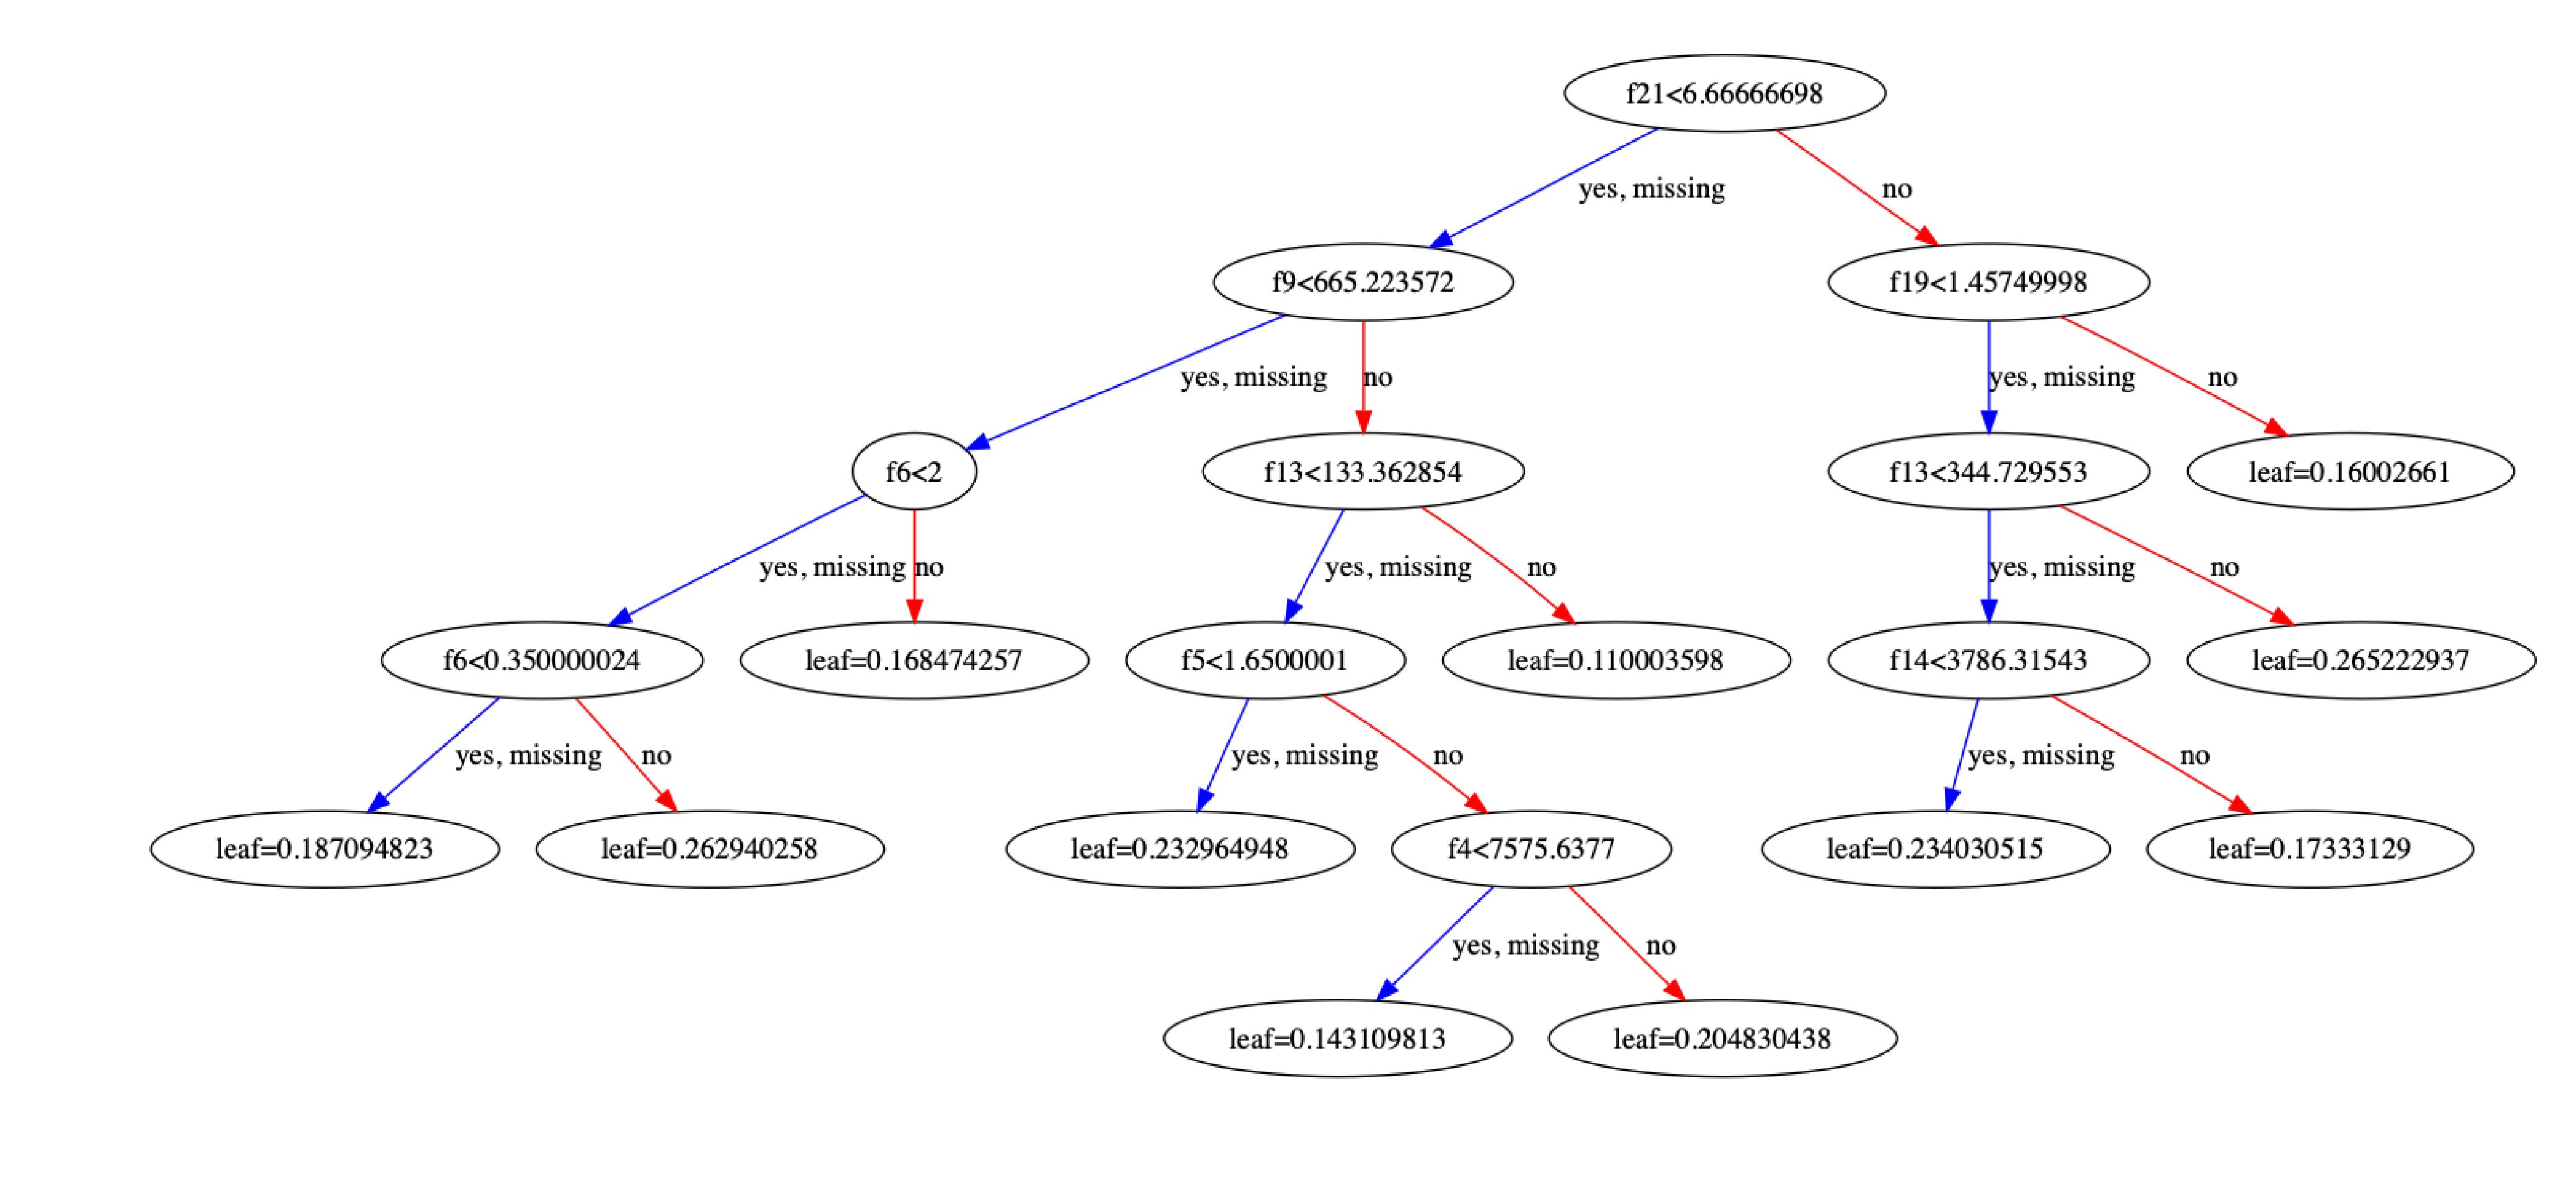

In [302]:
fig = plt.figure(num=None, figsize=(10, 10), dpi=500, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)
plot_tree(model, num_trees=10, ax = ax1)
plt.show()

In [196]:
#baseline  MSE: 0.5868
baseline_vector = []
for i, m in enumerate(date_data['mood']):
    if i==0:
        continue
    baseline_vector.append(date_data['mood'].iloc[i-1])

x, y =np.array(baseline_vector).reshape(-1,1) , np.array(date_data['mood']).reshape(-1,1)

accuracy = mean_squared_error(y[1:], x)
print("MSE: {:.4}" .format(accuracy))

MSE: 0.4717


In [ ]:
#MSEs_total= []
# for each parameter combination:
    #folds = split(train_set)
    #MSEs = []
    #for i, fold in enumerate(folds):
        #if i==len(folds) : break
        # train on folds[:i]
        #test on folds[i+1]
        #MSEs.append(test)
    #MSEs_tota.append(mean(MSEs))
#argmax(MSEs_total)

ALL_DATA = Test+ Train + Validation
